In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import statistics
import random
import cnn
import numpy as np
import pickle
import os
from cnn import load_CIFAR
from matplotlib.pyplot import imshow
loader_train, loader_val, loader_test = load_CIFAR(path='./datasets/')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [13]:
def check_accuracy_part(loader, model):
  if loader.dataset.train:
    print('Checking accuracy on validation set')
  else:
    print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device='cpu', dtype=torch.float)  # move to device, e.g. GPU
      y = y.to(device='cpu', dtype=torch.long)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

In [20]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule
  
  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update
  
  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd
        
def train_part(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.
  
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for
  
  Returns: Nothing, but prints model accuracies during training.
  """
  model = model.to(device='cpu')  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  print_every = 100
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)
  for e in range(epochs):
    
    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)
    
    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device='cpu', dtype=torch.float)  # move to device, e.g. GPU
      y = y.to(device='cpu', dtype=torch.long).clamp(min=2,max=7)
     
      scores = model(x)
      loss = F.cross_entropy(scores, y)
     
      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

In [21]:
from cnn import initialize_cnn
model, optimizer = initialize_cnn()
print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.

Architecture:
Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


Epoch 0, Iteration 0, loss = 2.4222
Checking accuracy on validation set
Got 108 / 1000 correct (10.80)

Epoch 0, Iteration 100, loss = 1.4196
Checking accuracy on validation set
Got 163 / 1000 correct (16.30)

Epoch 0, Iteration 200, loss = 1.2614
Checking accuracy on validation set
Got 247 / 1000 correct (24.70)

Epoch 0, Iteration 300, loss = 1.2698
Checking accuracy on validation set
Got 234 / 1000 correct (23.40)

Epoch 0, Iteration 400, loss = 1.0837
Checking accuracy on validation set
Got 242 / 1000 correct (24.20)

Epoch 0, Iteration 500, loss = 1.1742
Checking accuracy on validation set
Got 277 / 1000 correct (27.70)

Epoch 0, Iteration 600, loss = 1.1062
Checking accuracy on validation set
Got 234 / 1000 correct (23.40)

Epoch 0, Iteration 700, loss = 1.0743
Checking accuracy on validation set
Got 277 / 1000 correct (27.70)

Epoch 0, Iteration 765, loss = 0.9993
Checking accuracy on validation set
Got 305 / 1000 correct (30.50)



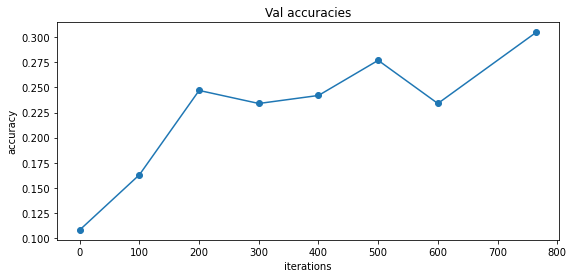

In [22]:
acc_hist_part, itr = train_part(model, optimizer)
plt.title('Val accuracies')
plt.plot(itr, acc_hist_part, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()